# Applying the trigger logic to all districts


In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
# Data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from pathlib import Path
from matplotlib.patches import Rectangle
import calendar

import os
import re
import rasterio
import geopandas as gpd
import rasterstats as rs
from fuzzywuzzy import process
from unidecode import unidecode
from scipy.stats.mstats import winsorize
from src.constants import *
from src.utils import *

# Display settings
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.1f}".format
sns.set(style="whitegrid")

In [3]:
# load admin boundaries
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm2 = gpd.read_file(adm2_path)

In [4]:
district_df = pd.read_csv(
    Path(os.getenv("AA_DATA_DIR"))
    / "private"
    / "processed"
    / "moz"
    / "cholera"
    / "cholera_data_all_cleaned.csv"
)
# only keep those with week values
district_df = district_df[district_df["week"].notna()]

In [5]:
# maputo city values are divided into different admin units which are not admin 3
# we should start by summing all values for maputo city
summed = (
    district_df[district_df["province"] == "Maputo Cidade"]
    .groupby(["year", "week"], as_index=False)
    .sum(numeric_only=True)
)
summed["province"] = "Maputo Cidade"
summed["district"] = "Maputo Cidade"
summed
df_rest = district_df[district_df["province"] != "Maputo Cidade"]
district_df = pd.concat([df_rest, summed], ignore_index=True)
district_df

province       district  year  week   cases
0       Cabo Delgado        Ancuabe  2017   1.0   104.0
1       Cabo Delgado        Ancuabe  2017   2.0   103.0
2       Cabo Delgado        Ancuabe  2017   3.0    81.0
3       Cabo Delgado        Ancuabe  2017   4.0    94.0
4       Cabo Delgado        Ancuabe  2017   5.0    84.0
...              ...            ...   ...   ...     ...
60895  Maputo Cidade  Maputo Cidade  2025  19.0   928.0
60896  Maputo Cidade  Maputo Cidade  2025  20.0 1,066.0
60897  Maputo Cidade  Maputo Cidade  2025  21.0 1,082.0
60898  Maputo Cidade  Maputo Cidade  2025  22.0 1,200.0
60899  Maputo Cidade  Maputo Cidade  2025  23.0   724.0

[60900 rows x 5 columns]

In [6]:
# testing out winsorization
winsorized_values = district_df.groupby(["province", "district"])[
    "cases"
].transform(
    lambda x: winsorize(
        x, limits=[winsorising_lower_limit, winsorising_upper_limit]
    )
)
district_df["cases_winsorized"] = winsorized_values

In [7]:
# using the 2025 file
gdf_adm2_pop = pd.read_csv(
    Path(AA_DATA_DIR)
    / "public"
    / "processed"
    / "moz"
    / "worldpop"
    / "adm2_population_totals.csv"
)
gdf_adm2 = gdf_adm2.merge(
    gdf_adm2_pop,
    how="left",
    on="ADM2_PCODE",
    suffixes=("", "_pop"),
)

In [8]:
# it seems the admin bounds districts are not matching the cholera data ones
# trying some fuzzy matching to see if we can get a match


# add the population data to the gdf
pop_df = gdf_adm2[["ADM2_PT", "ADM1_PT", "sum_population"]].copy()
district_df.loc[:, "district_norm"] = district_df["district"].apply(normalize)
pop_df["ADM2_PT_norm"] = pop_df["ADM2_PT"].apply(normalize)
mapping = {}
for name in district_df["district_norm"]:
    result = process.extractOne(name, pop_df["ADM2_PT_norm"])
    if result:
        match, score = result[0], result[1]
    if score >= 80:
        match_row = pop_df[pop_df["ADM2_PT_norm"] == match].iloc[0]
        mapping[name] = match_row["ADM2_PT"]
district_df["matched_name"] = district_df["district_norm"].map(mapping)

In [9]:
# cidade de maputo is split into various smaller units
# inhassunge is labelled as inhass
# lago niassa is different from lago
manual_map = {
    "inhass": "Inhassunge",
}
for name in district_df["district_norm"]:
    if "maputo" in name and "city" in name:
        manual_map[name] = "Cidade de Maputo"
mapping.update(manual_map)
district_df["matched_name"] = district_df["district_norm"].map(mapping)

In [10]:
district_df["date"] = pd.to_datetime(
    district_df["year"].astype(str)
    + district_df["week"].astype(int).astype(str).str.zfill(2)
    + "1",
    format="%G%V%u",
)

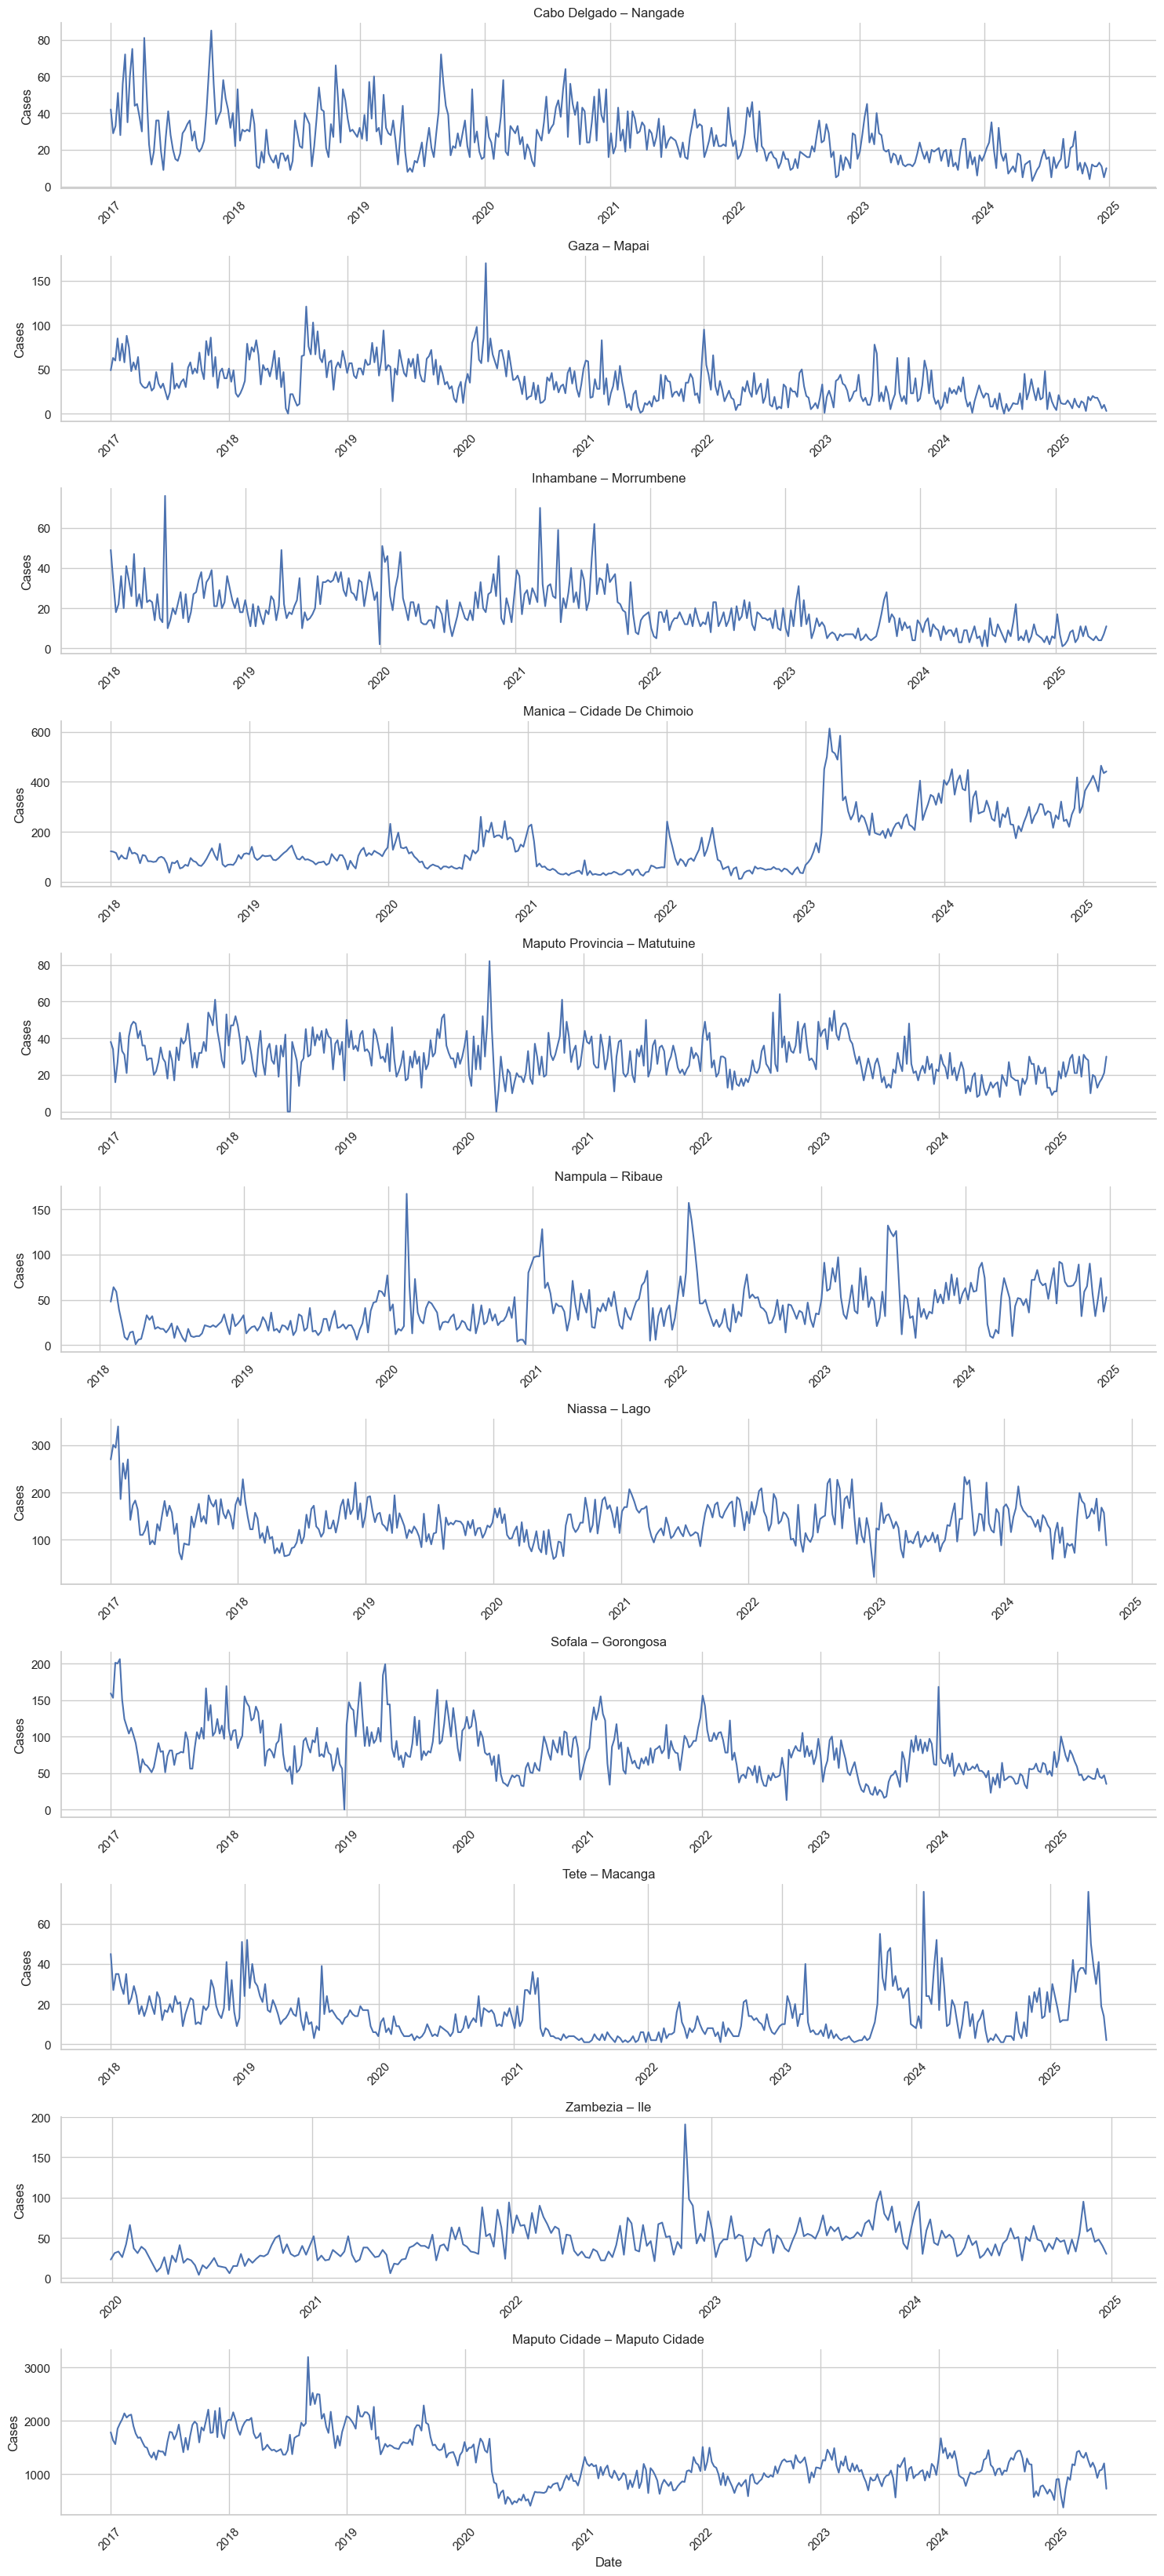

In [11]:
# Plot a random sample of one district per province
# to avoid too many plots, we will sample one district per province
selected_districts = (
    district_df.groupby("province")["district"]
    .apply(lambda x: x.sample(n=1, random_state=42).iloc[0])
    .tolist()
)
filtered_df = district_df[district_df["district"].isin(selected_districts)]
district_labels = filtered_df.groupby("province")["district"].first().to_dict()
g = sns.FacetGrid(
    filtered_df,
    row="province",
    sharex=False,
    sharey=False,
    height=3,
    aspect=5,
)
g.map_dataframe(sns.lineplot, x="date", y="cases_winsorized")

for ax in g.axes.flat:
    province = ax.get_title().replace("province = ", "")
    district = district_labels.get(province, "")
    ax.set_title(f"{province} – {district}")

g.set_axis_labels("Date", "Cases")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.tight_layout()
plt.show()

In [12]:
# Normalise the cholera data by population
district_pop_df = district_df.merge(
    pop_df, left_on="matched_name", right_on="ADM2_PT", how="left"
)

In [13]:
pop_df[pop_df["ADM2_PT"] == "Cidade De Maputo"]

ADM2_PT      ADM1_PT  sum_population      ADM2_PT_norm
30  Cidade De Maputo  Maputo City     1,018,559.4  cidade de maputo

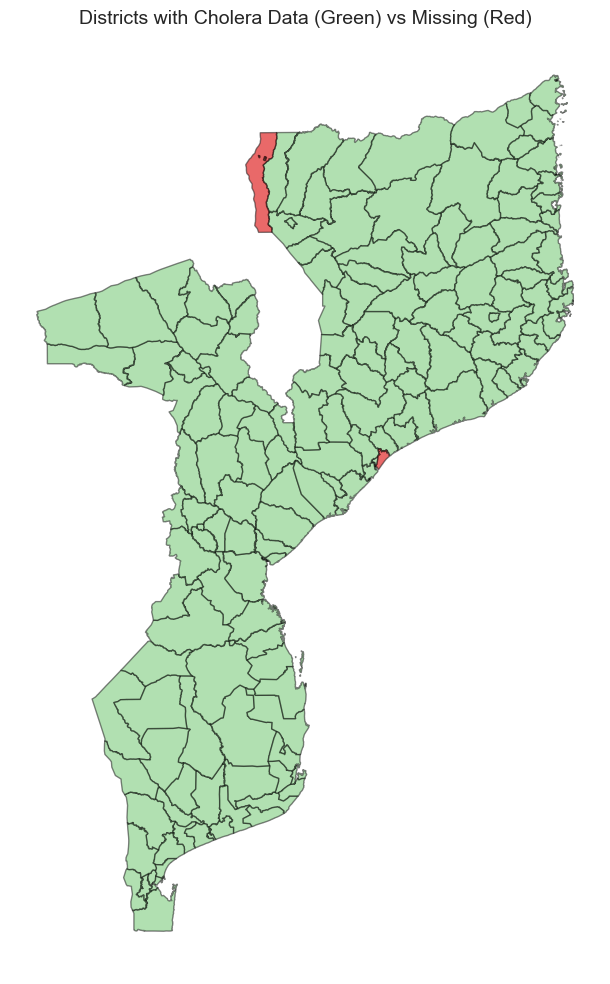

In [14]:
base = gdf_adm2.plot(color="lightgrey", edgecolor="white", figsize=(10, 10))

matched_districts = district_pop_df["ADM2_PT"].unique()
gdf_matched = gdf_adm2[gdf_adm2["ADM2_PT"].isin(matched_districts)]
gdf_matched.plot(ax=base, color="lightgreen", edgecolor="black", alpha=0.5)

gdf_missing = gdf_adm2[~gdf_adm2["ADM2_PT"].isin(matched_districts)]
gdf_missing.plot(ax=base, color="red", edgecolor="black", alpha=0.5)

plt.title("Districts with Cholera Data (Green) vs Missing (Red)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
# not all districts are in the cholera data
gdf_missing[["ADM2_PT", "ADM1_PT"]]

ADM2_PT   ADM1_PT
53     Ilha Licom    Niassa
54  Ilha Risunodo    Niassa
60    Lago Niassa    Niassa
85       Maquival  Zambezia

In [16]:
# check if merging is done well
# it should be empty if all the names are matched
district_pop_df[district_pop_df["ADM2_PT"].isna()][
    [
        "province",
        "district",
        "matched_name",
    ]
].drop_duplicates()

Empty DataFrame
Columns: [province, district, matched_name]
Index: []

In [17]:
# No district called Sofala

In [18]:
gdf_adm2[gdf_adm2["ADM1_PT"].isin(["Maputo City"])]

Shape_Leng  Shape_Area           ADM2_PT ADM2_PCODE ADM2_REF ADM2ALT1PT  \
30         1.8         0.0  Cidade De Maputo     MZ0601     None       None   

   ADM2ALT2PT      ADM1_PT ADM1_PCODE     ADM0_EN     ADM0_PT ADM0_PCODE  \
30       None  Maputo City       MZ06  Mozambique  Moçambique         MZ   

         date    validOn     validTo  \
30 2019-04-02 2019-06-07  0000/00/00   

                                             geometry  ADM1_PT_pop  \
30  MULTIPOLYGON (((32.99494 -25.97092, 32.99488 -...  Maputo City   

         ADM2_PT_pop  sum_population  
30  Cidade De Maputo     1,018,559.4

In [19]:
# now, normalise the cholera data by population
district_pop_df["cases_per_100k"] = (
    district_pop_df["cases_winsorized"] / district_pop_df["sum_population"]
) * 100000
district_pop_df["cases_per_100k"].describe()

count   57,800.0
mean        40.0
std         44.3
min          0.0
25%         10.8
50%         26.5
75%         54.2
max        892.1
Name: cases_per_100k, dtype: float64

In [20]:
# check the distribution of the cases per 100k
# look at 99th percentile to set a trigger for each province OR 4x weekly increase in cases
# Calculate percentiles per province
percentiles = (
    district_pop_df[district_pop_df["cases_per_100k"] > 0]
    .groupby("province")["cases_per_100k"]
    .quantile([0.99])
    .unstack()
)

# Merge percentiles back into the main df
district_df_with_percentiles = district_pop_df.merge(
    percentiles.rename(columns={0.99: "p99"}),
    left_on="province",
    right_index=True,
    how="left",
)
district_df_with_percentiles["weekly_pct_increase"] = (
    district_df_with_percentiles
    # group by district and calculate percentage change
    .groupby("district")["cases_per_100k"].pct_change(fill_method=None)
    * 100
)

In [21]:
# Check if cases cross the thresholds
district_df_with_percentiles["above_99th"] = (
    district_df_with_percentiles["cases_per_100k"]
    > district_df_with_percentiles["p99"]
)
district_df_with_percentiles["above_4x"] = (
    district_df_with_percentiles["weekly_pct_increase"] >= 300
)
district_df_with_percentiles["threshold_crossed"] = (
    district_df_with_percentiles["above_99th"]
    | district_df_with_percentiles["above_4x"]
)
district_df_with_percentiles = district_df_with_percentiles.sort_values(
    ["district", "year", "week"]
)
# also adding the condition of at least x cases for 3 consecutive weeks for a province
province_df = (
    district_df_with_percentiles.groupby(["province", "year", "week"])[
        "cases"
    ].sum()
).reset_index()
province_df["adm1_above_limit"] = province_df["cases"] >= province_case_limit
province_df = province_df.sort_values(["province", "year", "week"])
province_df["adm1_threshold_crossed"] = (
    province_df["adm1_above_limit"]
    & province_df.groupby("province")["adm1_above_limit"].shift(1)
    & province_df.groupby("province")["adm1_above_limit"].shift(2)
)
province_df[province_df["adm1_threshold_crossed"]]

Empty DataFrame
Columns: [province, year, week, cases, adm1_above_limit, adm1_threshold_crossed]
Index: []

In [22]:
district_df_with_percentiles = district_df_with_percentiles.merge(
    province_df[
        [
            "province",
            "year",
            "week",
            "adm1_above_limit",
            "adm1_threshold_crossed",
        ]
    ],
    on=["province", "year", "week"],
    how="left",
)
district_df_with_percentiles[
    (district_df_with_percentiles["adm1_threshold_crossed"])
    & (district_df_with_percentiles["province"] == "Sofala")
]

Empty DataFrame
Columns: [province, district, year, week, cases, cases_winsorized, district_norm, matched_name, date, ADM2_PT, ADM1_PT, sum_population, ADM2_PT_norm, cases_per_100k, p99, weekly_pct_increase, above_99th, above_4x, threshold_crossed, adm1_above_limit, adm1_threshold_crossed]
Index: []

In [23]:
# Create the new column: True only if this week and the previous two weeks are above the 99th percentile or 4x increase
district_df_with_percentiles["three_consec_crossing"] = (
    district_df_with_percentiles["threshold_crossed"]
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(1)
    & district_df_with_percentiles.groupby("district")[
        "threshold_crossed"
    ].shift(2)
    & (
        (
            (district_df_with_percentiles["district"].isin(capital_districts))
            & (district_df_with_percentiles["cases"] >= capitals_threshold)
            & (
                district_df_with_percentiles["cases"].shift(1)
                >= capitals_threshold
            )
            & (
                district_df_with_percentiles["cases"].shift(2)
                >= capitals_threshold
            )
        )
        | (
            (~district_df_with_percentiles["district"].isin(capital_districts))
            & (district_df_with_percentiles["cases"] >= default_threshold)
            & (
                district_df_with_percentiles["cases"].shift(1)
                >= default_threshold
            )
            & (
                district_df_with_percentiles["cases"].shift(2)
                >= default_threshold
            )
        )
    )
) | district_df_with_percentiles["adm1_threshold_crossed"]
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["province", "district"]].drop_duplicates()

province            district
2600             Sofala               Beira
4445               Tete        Cahora Bassa
8698             Niassa          Chimbonila
11347            Manica   Cidade De Chimoio
12586              Tete      Cidade De Tete
19412           Nampula  Ilha De Moçambique
21796           Nampula              Lalaua
27491          Zambezia             Maganja
28011              Tete               Magoe
28211  Maputo Provincia              Magude
28770            Niassa              Majune
31625     Maputo Cidade       Maputo Cidade
32807            Sofala            Maringue
36629            Niassa          Mavago (2)
50657           Nampula        Nacala-Porto
54765          Zambezia            Nicoadal

In [24]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].head(5)

province      district  year  week   cases  cases_winsorized  \
2600   Sofala         Beira  2023  11.0 1,729.0           1,729.0   
2601   Sofala         Beira  2023  12.0 1,844.0           1,844.0   
2602   Sofala         Beira  2023  13.0 1,362.0           1,362.0   
4445     Tete  Cahora Bassa  2024   8.0   359.0             359.0   
4446     Tete  Cahora Bassa  2024   9.0   294.0             294.0   

     district_norm     matched_name       date          ADM2_PT ADM1_PT  \
2600         beira  Cidade Da Beira 2023-03-13  Cidade Da Beira  Sofala   
2601         beira  Cidade Da Beira 2023-03-20  Cidade Da Beira  Sofala   
2602         beira  Cidade Da Beira 2023-03-27  Cidade Da Beira  Sofala   
4445  cahora bassa     Cahora Bassa 2024-02-19     Cahora Bassa    Tete   
4446  cahora bassa     Cahora Bassa 2024-02-26     Cahora Bassa    Tete   

      sum_population     ADM2_PT_norm  cases_per_100k   p99  \
2600       784,405.4  cidade da beira           220.4 150.1   
2601       784,405.4  cidade da beira           235.1 150.1   
2602       784,405.4  cidade da beira           173.6 150.1   
4445       183,887.1     cahora bassa           195.2 158.0   
4446       183,887.1     cahora bassa           159.9 158.0   

      weekly_pct_increase  above_99th  above_4x  threshold_crossed  \
2600                 31.7        True     False               True   
2601                  6.7        True     False               True   
2602                -26.1        True     False               True   
4445                 -5.0        True     False               True   
4446                -18.1        True     False               True   

      adm1_above_limit  adm1_threshold_crossed  three_consec_crossing  
2600             False                   False                   True  
2601             False                   False                   True  
2602             False                   False                   True  
4445             False                   False                   True  
4446             False                   False                   True

In [25]:
# Compute total cases and total cases relative to population per district per year
grouped = (
    district_df_with_percentiles.groupby(["province", "district", "year"])
    .agg(
        average_cases=("cases", "mean"),
        average_cases_per_100k=("cases_per_100k", "mean"),
    )
    .reset_index()
)
grouped

province district  year  average_cases  average_cases_per_100k
0     Cabo Delgado  Ancuabe  2017           62.8                    27.6
1     Cabo Delgado  Ancuabe  2018           69.1                    30.4
2     Cabo Delgado  Ancuabe  2019           56.2                    24.7
3     Cabo Delgado  Ancuabe  2020           48.5                    21.3
4     Cabo Delgado  Ancuabe  2021           52.9                    23.3
...            ...      ...   ...            ...                     ...
1183      Zambezia   Quelim  2020          402.7                    74.3
1184      Zambezia   Quelim  2021          399.8                    73.8
1185      Zambezia   Quelim  2022          372.2                    68.6
1186      Zambezia   Quelim  2023          360.4                    66.5
1187      Zambezia   Quelim  2024          327.9                    60.5

[1188 rows x 5 columns]

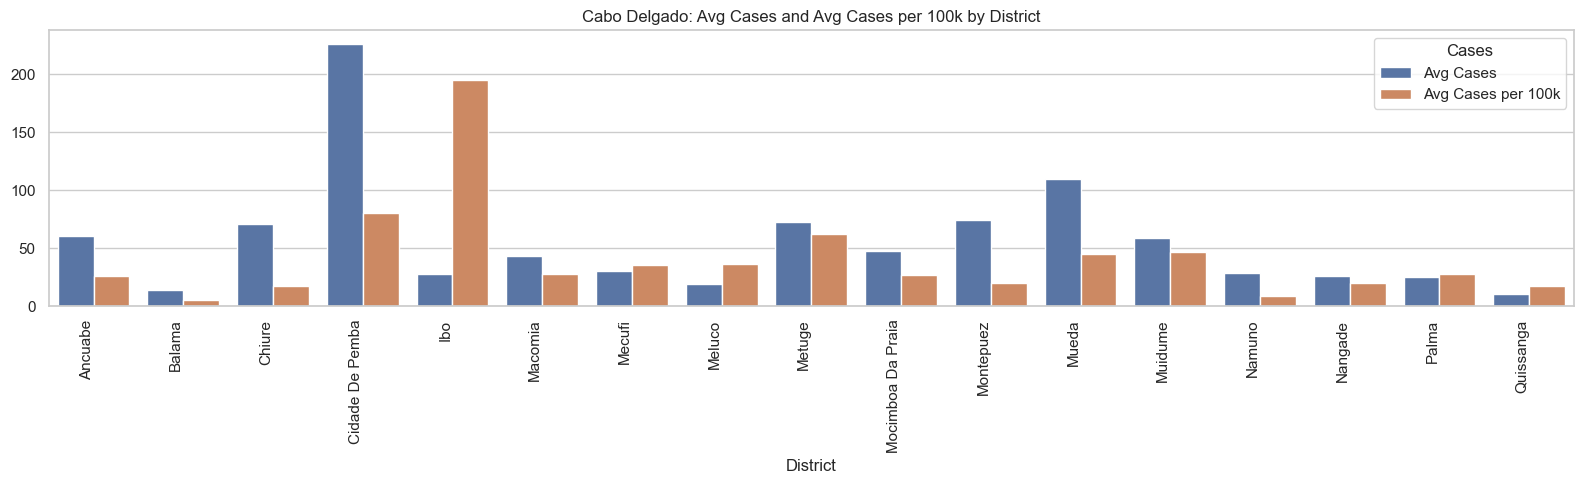

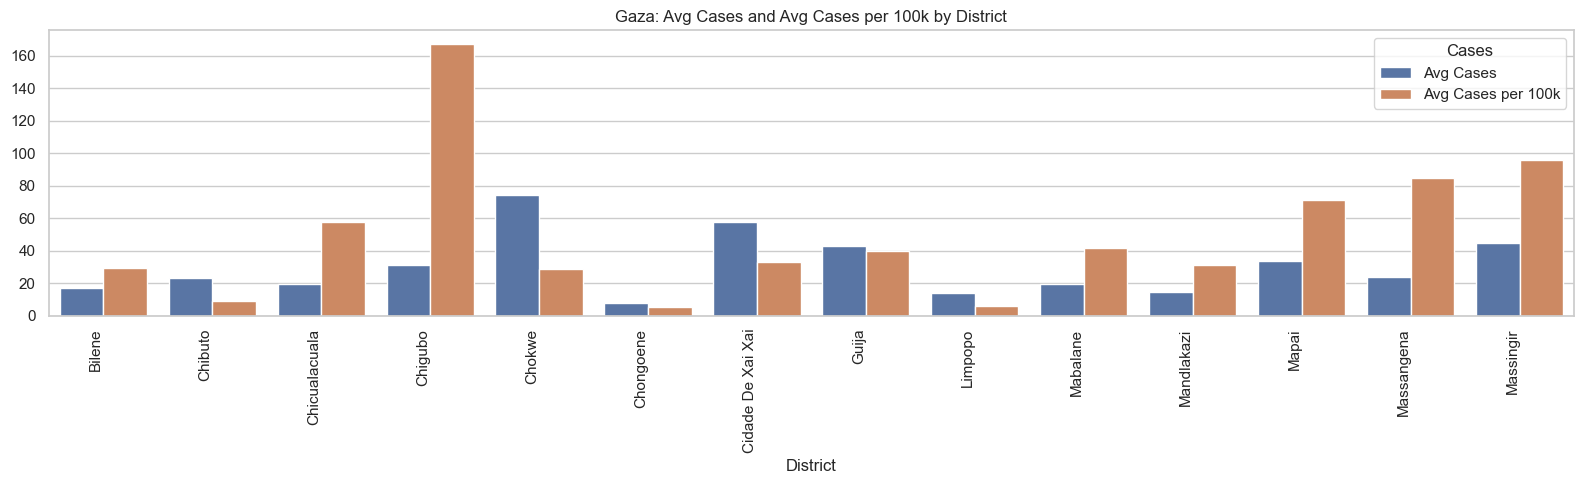

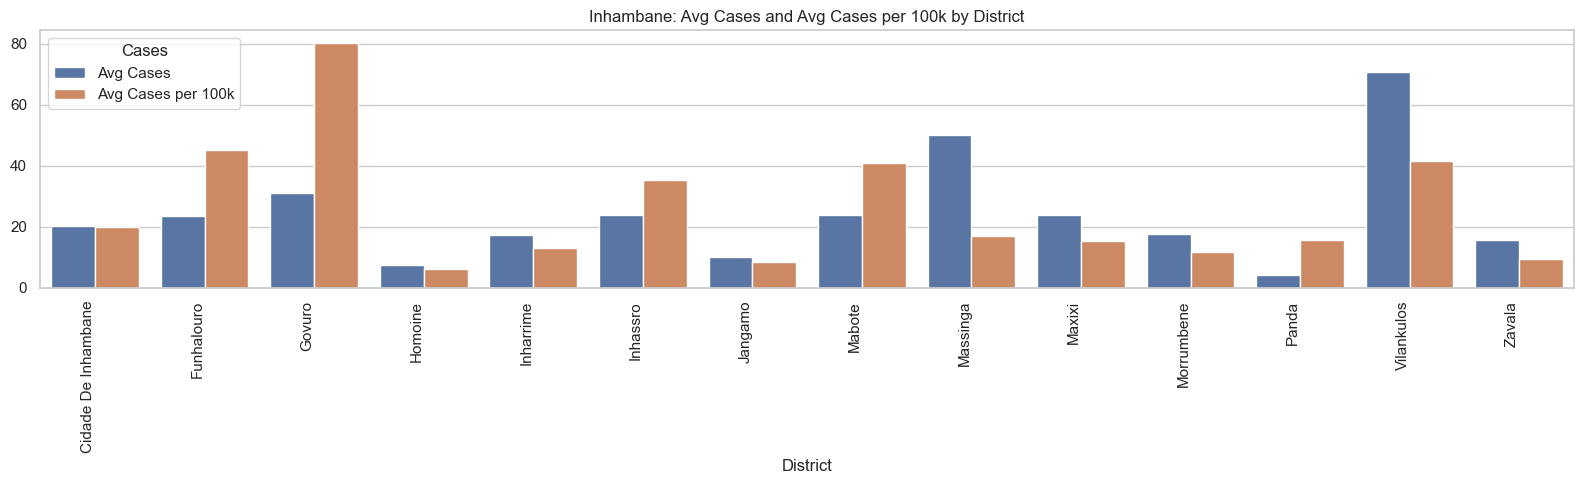

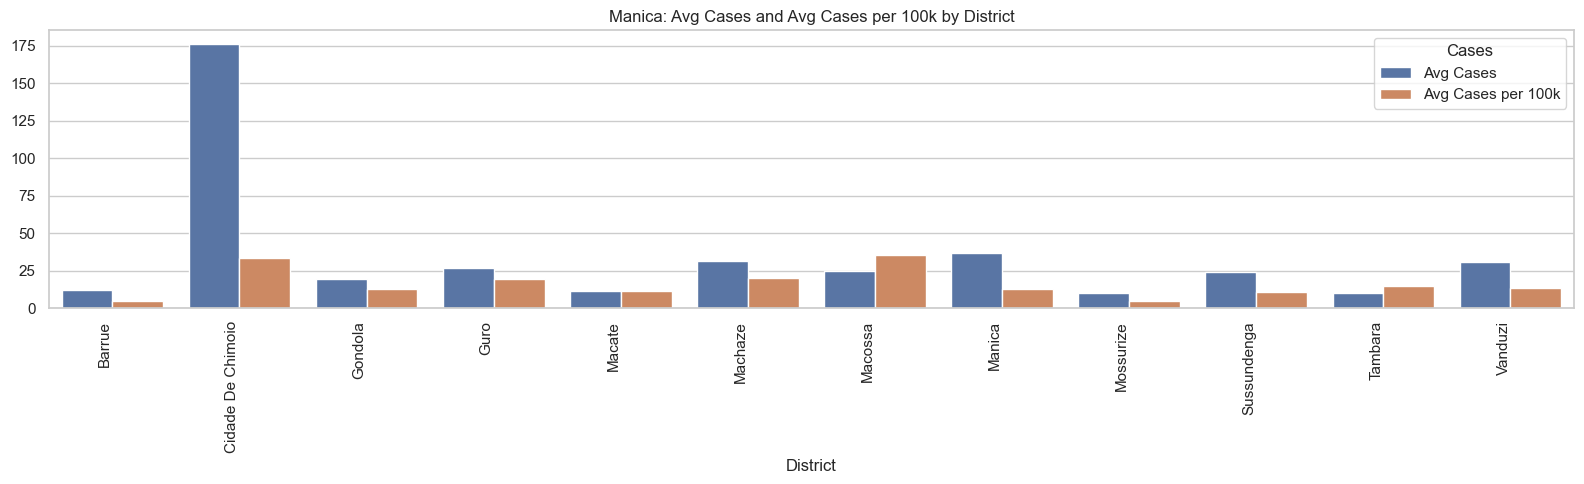

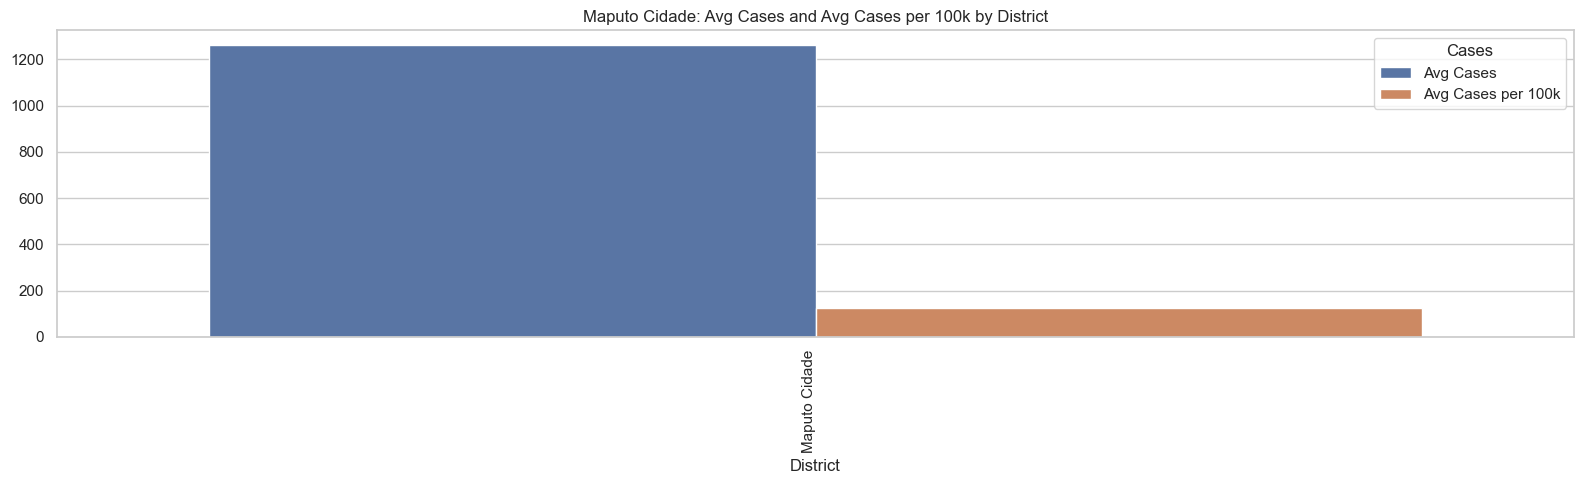

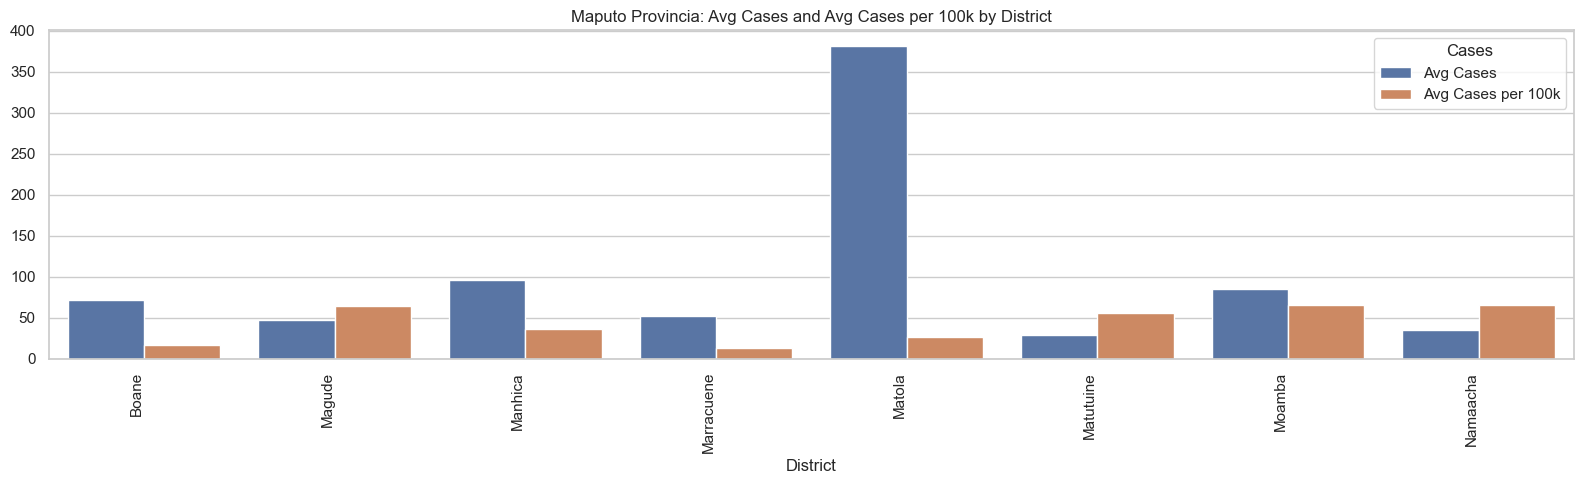

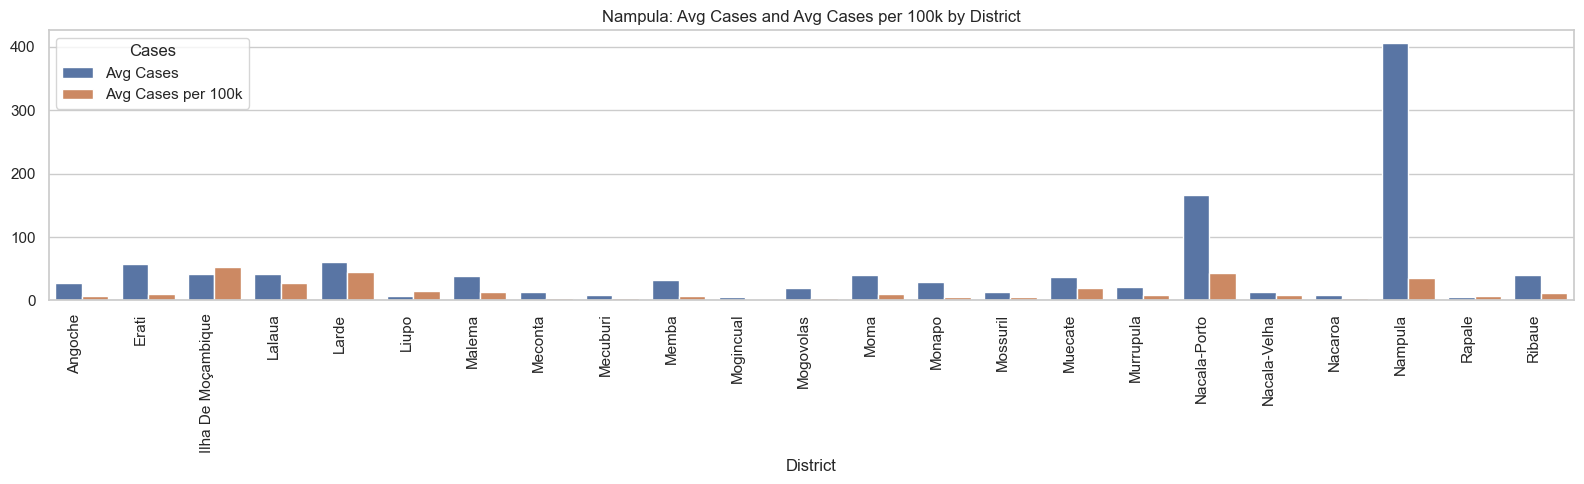

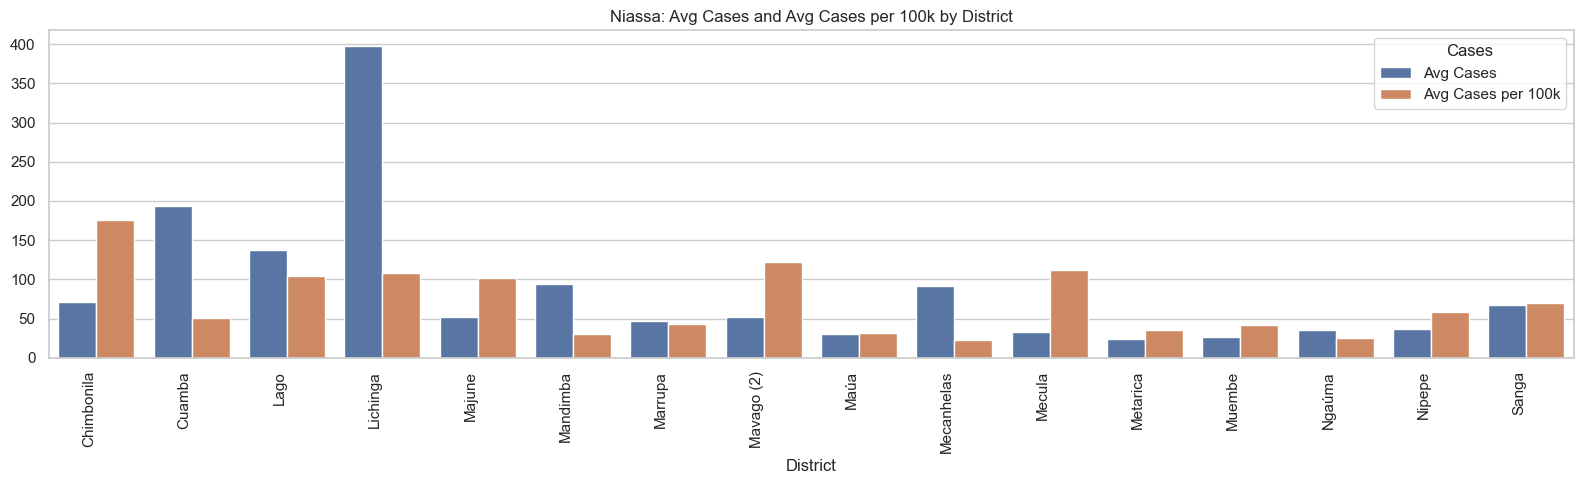

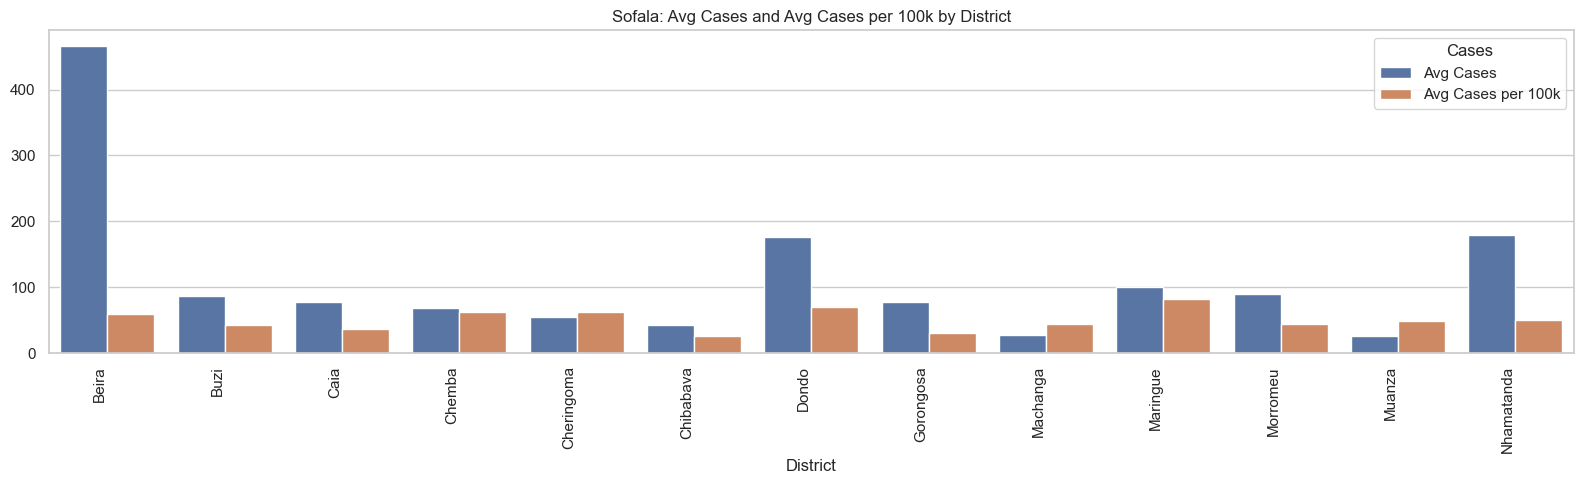

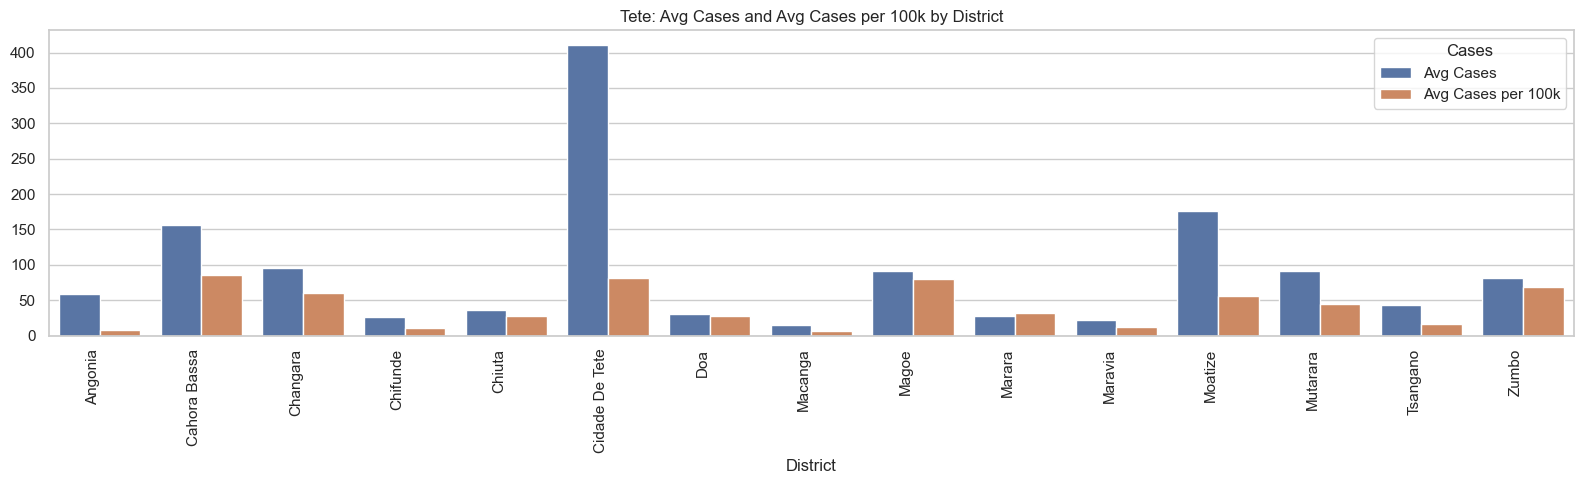

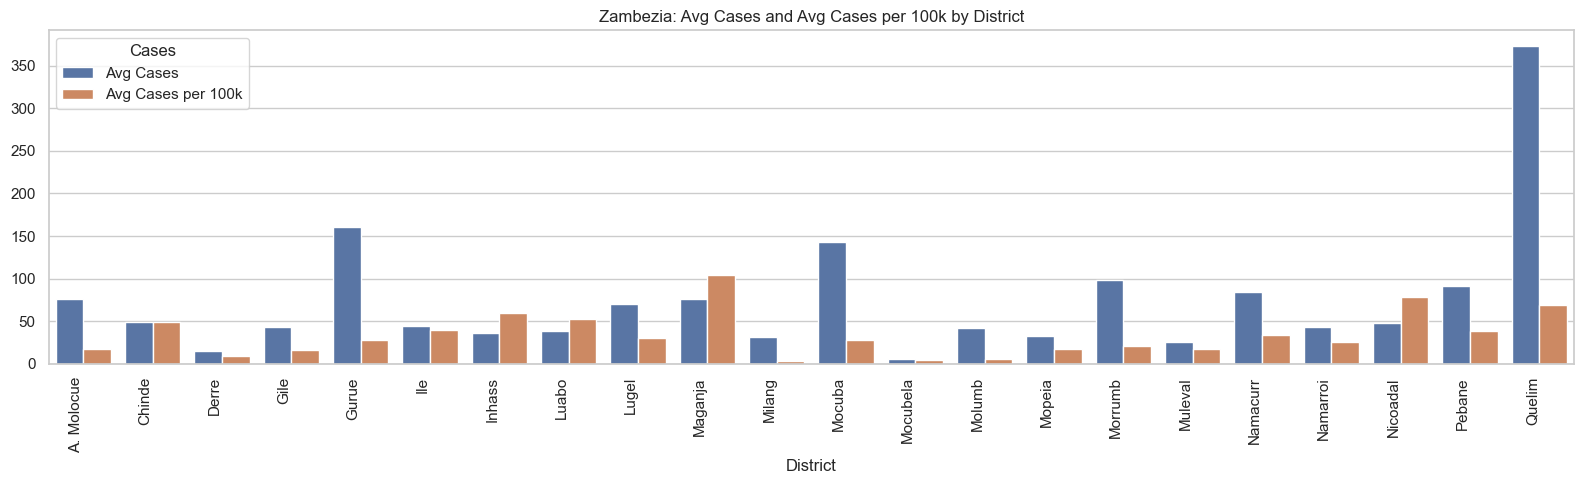

In [26]:
melted = grouped.melt(
    id_vars=["province", "district"],
    value_vars=["average_cases", "average_cases_per_100k"],
    var_name="metric",
    value_name="value",
)

# Rename for cleaner labels
melted["cases"] = melted["metric"].replace(
    {
        "average_cases": "Avg Cases",
        "average_cases_per_100k": "Avg Cases per 100k",
    }
)

# Plot
provinces = melted["province"].unique()

for province in provinces:
    df_prov = melted[melted["province"] == province]

    plt.figure(figsize=(16, 5))
    sns.barplot(
        data=df_prov,
        x="district",
        y="value",
        hue="cases",
        dodge=True,
        errorbar=None,
    )
    plt.title(f"{province}: Avg Cases and Avg Cases per 100k by District")
    plt.xlabel("District")
    plt.xticks(rotation=90, ha="right")
    plt.ylabel("")
    plt.legend(title="Cases")
    plt.tight_layout()
    plt.show()

In [27]:
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
][["year", "week"]].drop_duplicates().sort_values(["year", "week"])
# the number of districts by year and by province when the threshold was crossed
all_years = district_df_with_percentiles["year"].unique()
district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
].groupby(["province", "year"])["district"].nunique().unstack(
    fill_value=0
).reindex(
    columns=sorted(all_years), fill_value=0
)

year              2017  2018  2019  2020  2021  2022  2023  2024  2025
province                                                              
Manica               0     0     0     0     0     0     1     0     1
Maputo Cidade        0     1     0     0     0     0     0     0     0
Maputo Provincia     0     1     1     0     0     0     0     0     0
Nampula              0     0     0     1     2     2     0     0     0
Niassa               0     1     0     0     1     2     1     0     0
Sofala               1     0     1     0     0     1     1     0     0
Tete                 0     0     0     0     0     0     2     3     1
Zambezia             0     0     0     1     1     0     1     1     0

In [28]:
# Filter if you want only the crossings
crossed_99th = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"]
]

district_trigger_99th = (
    crossed_99th.groupby(["province", "district", "year"])["week"]
    .count()
    .reset_index(name="week_count")
)
district_trigger_99th

province            district  year  week_count
0             Manica   Cidade De Chimoio  2023           5
1             Manica   Cidade De Chimoio  2025           2
2      Maputo Cidade       Maputo Cidade  2018           2
3   Maputo Provincia              Magude  2018           2
4   Maputo Provincia              Magude  2019           1
5            Nampula  Ilha De Moçambique  2020           2
6            Nampula  Ilha De Moçambique  2021           6
7            Nampula              Lalaua  2022           2
8            Nampula        Nacala-Porto  2021           7
9            Nampula        Nacala-Porto  2022           1
10            Niassa          Chimbonila  2018           3
11            Niassa          Chimbonila  2022           8
12            Niassa          Chimbonila  2023           1
13            Niassa              Majune  2021           1
14            Niassa          Mavago (2)  2022           1
15            Sofala               Beira  2023           3
16            Sofala            Maringue  2017           1
17            Sofala            Maringue  2019           6
18            Sofala            Maringue  2022           1
19              Tete        Cahora Bassa  2024           4
20              Tete        Cahora Bassa  2025           2
21              Tete      Cidade De Tete  2023           3
22              Tete      Cidade De Tete  2024           2
23              Tete               Magoe  2023           5
24              Tete               Magoe  2024           1
25          Zambezia             Maganja  2020           1
26          Zambezia             Maganja  2021           3
27          Zambezia             Maganja  2024           7
28          Zambezia            Nicoadal  2023           1

In [29]:
district_df_with_percentiles[
    district_df_with_percentiles["district"].isin(
        district_trigger_99th["district"].unique()
    )
]

province  district  year  week  cases  cases_winsorized district_norm  \
2278     Sofala     Beira  2017   1.0  513.0             513.0         beira   
2279     Sofala     Beira  2017   2.0  517.0             517.0         beira   
2280     Sofala     Beira  2017   3.0  494.0             494.0         beira   
2281     Sofala     Beira  2017   4.0  463.0             463.0         beira   
2282     Sofala     Beira  2017   5.0  533.0             533.0         beira   
...         ...       ...   ...   ...    ...               ...           ...   
54851  Zambezia  Nicoadal  2024  48.0   31.0              31.0      nicoadal   
54852  Zambezia  Nicoadal  2024  49.0   26.0              26.0      nicoadal   
54853  Zambezia  Nicoadal  2024  50.0   29.0              29.0      nicoadal   
54854  Zambezia  Nicoadal  2024  51.0   27.0              27.0      nicoadal   
54855  Zambezia  Nicoadal  2024  52.0   23.0              23.0      nicoadal   

          matched_name       date          ADM2_PT   ADM1_PT  sum_population  \
2278   Cidade Da Beira 2017-01-02  Cidade Da Beira    Sofala       784,405.4   
2279   Cidade Da Beira 2017-01-09  Cidade Da Beira    Sofala       784,405.4   
2280   Cidade Da Beira 2017-01-16  Cidade Da Beira    Sofala       784,405.4   
2281   Cidade Da Beira 2017-01-23  Cidade Da Beira    Sofala       784,405.4   
2282   Cidade Da Beira 2017-01-30  Cidade Da Beira    Sofala       784,405.4   
...                ...        ...              ...       ...             ...   
54851        Nicoadala 2024-11-25        Nicoadala  Zambezia        61,220.4   
54852        Nicoadala 2024-12-02        Nicoadala  Zambezia        61,220.4   
54853        Nicoadala 2024-12-09        Nicoadala  Zambezia        61,220.4   
54854        Nicoadala 2024-12-16        Nicoadala  Zambezia        61,220.4   
54855        Nicoadala 2024-12-23        Nicoadala  Zambezia        61,220.4   

          ADM2_PT_norm  cases_per_100k   p99  weekly_pct_increase  above_99th  \
2278   cidade da beira            65.4 150.1                  NaN       False   
2279   cidade da beira            65.9 150.1                  0.8       False   
2280   cidade da beira            63.0 150.1                 -4.4       False   
2281   cidade da beira            59.0 150.1                 -6.3       False   
2282   cidade da beira            67.9 150.1                 15.1       False   
...                ...             ...   ...                  ...         ...   
54851        nicoadala            50.6 135.9                -31.1       False   
54852        nicoadala            42.5 135.9                -16.1       False   
54853        nicoadala            47.4 135.9                 11.5       False   
54854        nicoadala            44.1 135.9                 -6.9       False   
54855        nicoadala            37.6 135.9                -14.8       False   

       above_4x  threshold_crossed  adm1_above_limit  adm1_threshold_crossed  \
2278      False              False             False                   False   
2279      False              False             False                   False   
2280      False              False             False                   False   
2281      False              False             False                   False   
2282      False              False             False                   False   
...         ...                ...               ...                     ...   
54851     False              False             False                   False   
54852     False              False             False                   False   
54853     False              False             False                   False   
54854     False              False             False                   False   
54855     False              False             False                   False   

       three_consec_crossing  
2278                   False  
2279                   False  
2280                   False  
2281                   Fals

In [30]:
month_num = {
    month: idx for idx, month in enumerate(calendar.month_name) if month
}


def highlight_month_boxes(data, cerf_y_lim="cases_per_100k", **kwargs):
    ax = plt.gca()

    # Add vertical lines
    consec_dates = data.loc[
        data["three_consec_crossing"], "date"
    ].sort_values()

    if not consec_dates.empty:
        # Convert to periods (daily)
        diffs = consec_dates.diff().dt.days.fillna(1)
        group = (diffs != 7).cumsum()  # Use 7 for weekly data

        for _, g in consec_dates.groupby(group):
            start = g.min()
            end = g.max()
            y_min = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].min()
            y_max = data.loc[
                (data["date"] >= start) & (data["date"] <= end),
                "cases_per_100k",
            ].max()
            ax.add_patch(
                Rectangle(
                    (start, 0),
                    end - start,
                    ax.get_ylim()[1],
                    facecolor="red",
                    alpha=0.5,
                    edgecolor="red",
                )
            )

    # Highlight selected months
    for year, month in highlight_cells:
        month_index = month_num.get(month)
        if not month_index:
            continue

        mask = (data["date"].dt.year == year) & (
            data["date"].dt.month == month_index
        )
        if not mask.any():
            continue

        month_data = data.loc[mask]
        x_min = month_data["date"].min()
        x_max = month_data["date"].max()
        y_min = max(0, month_data[cerf_y_lim].min() - 5)
        y_max = month_data[cerf_y_lim].max() + 5

        ax.add_patch(
            Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                facecolor="green",
                edgecolor="green",
                alpha=0.5,
                linewidth=1,
            )
        )

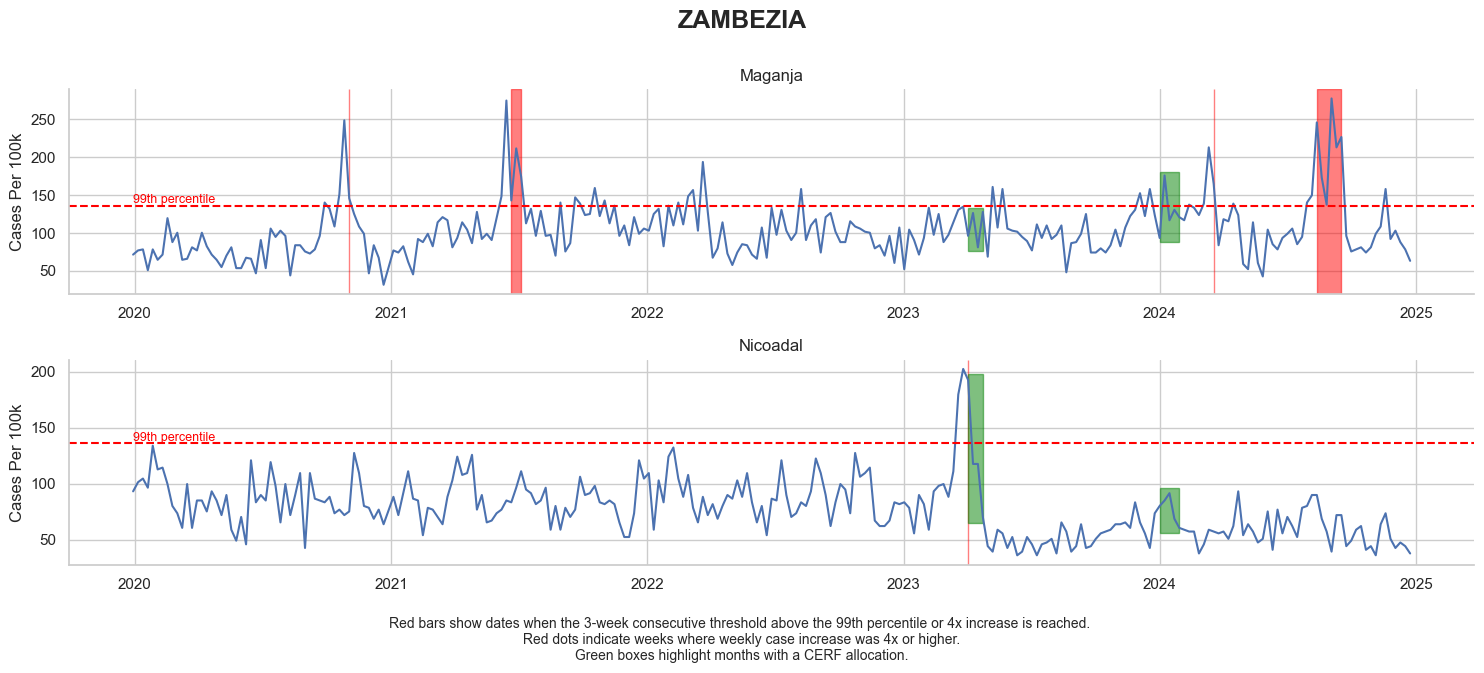

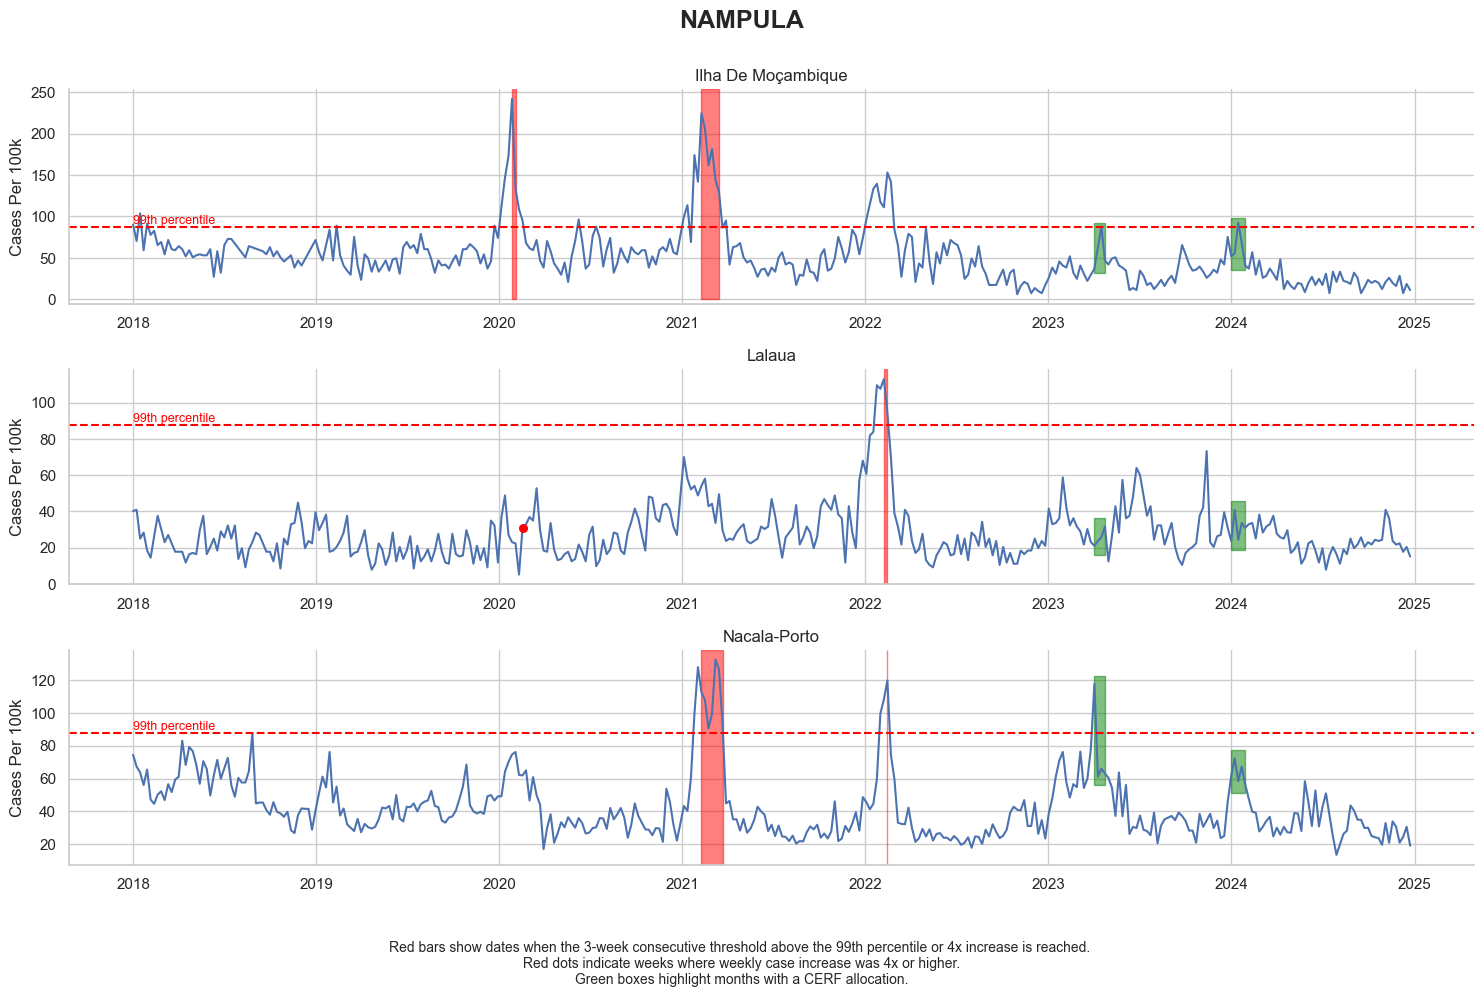

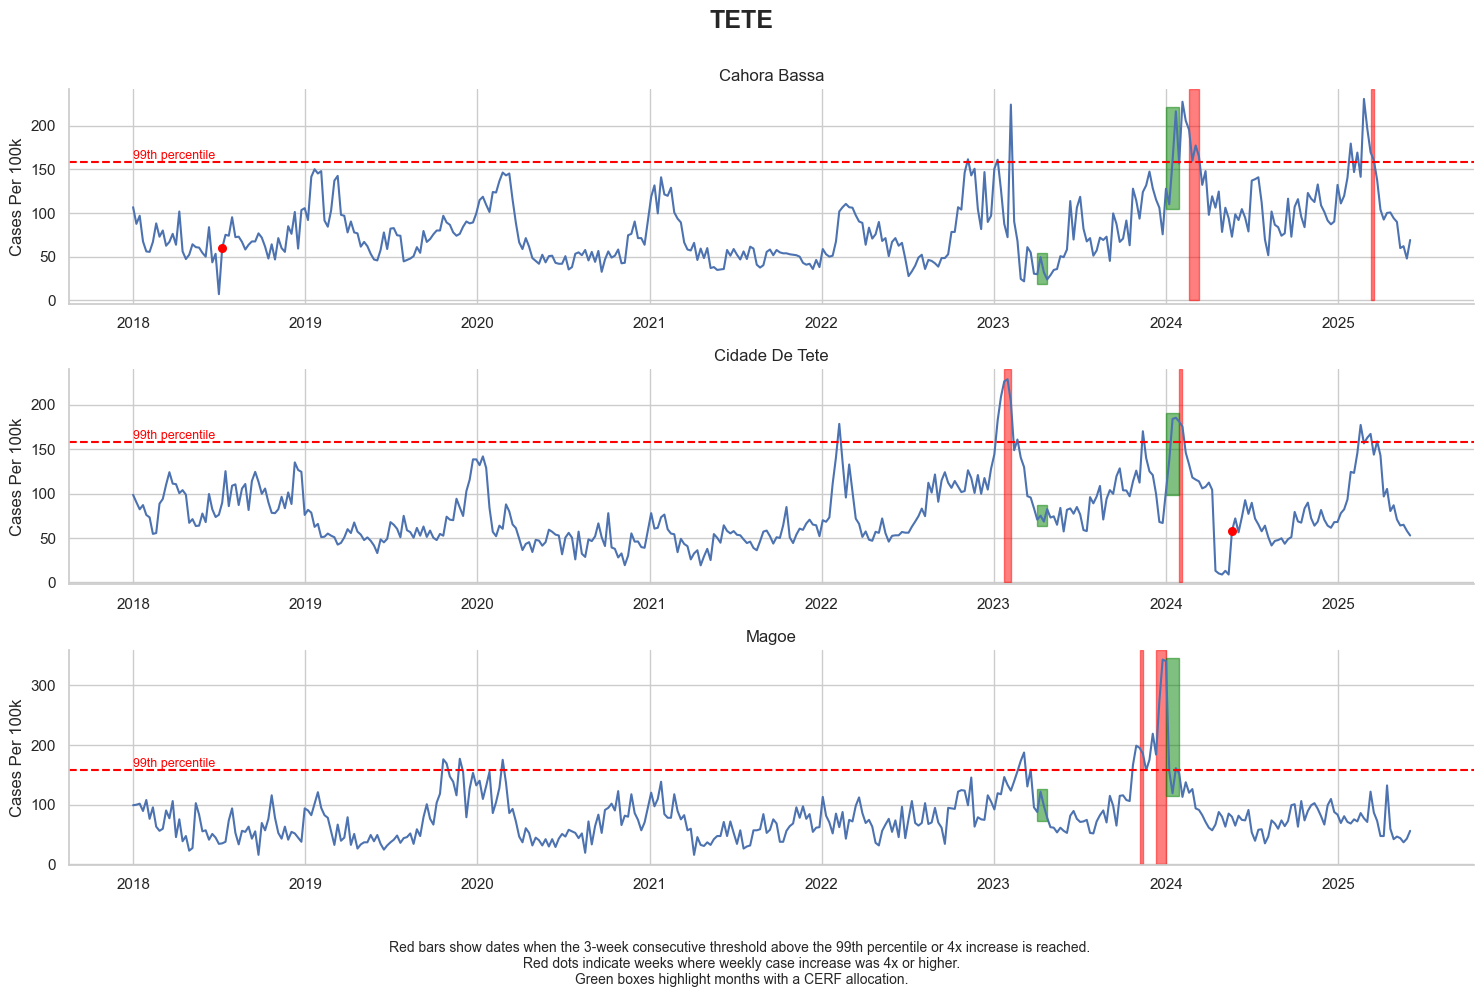

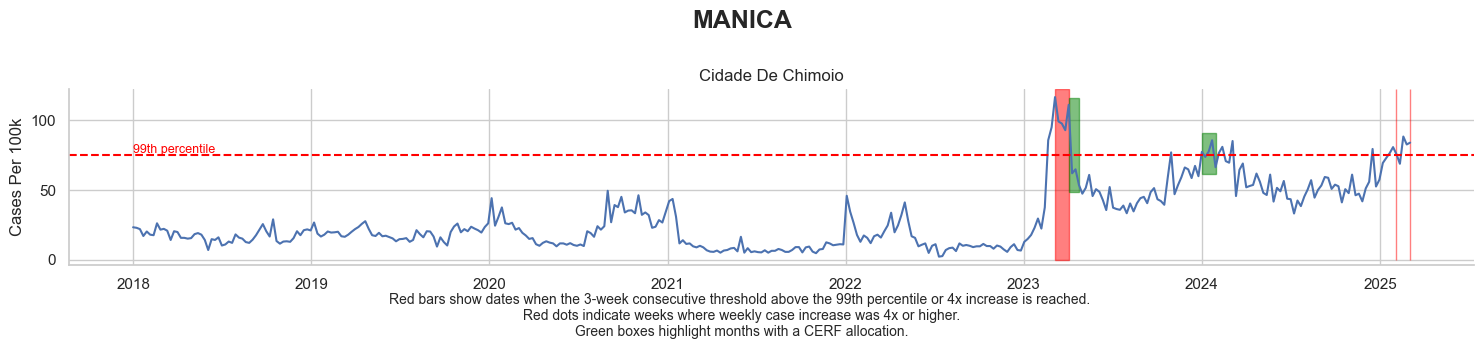

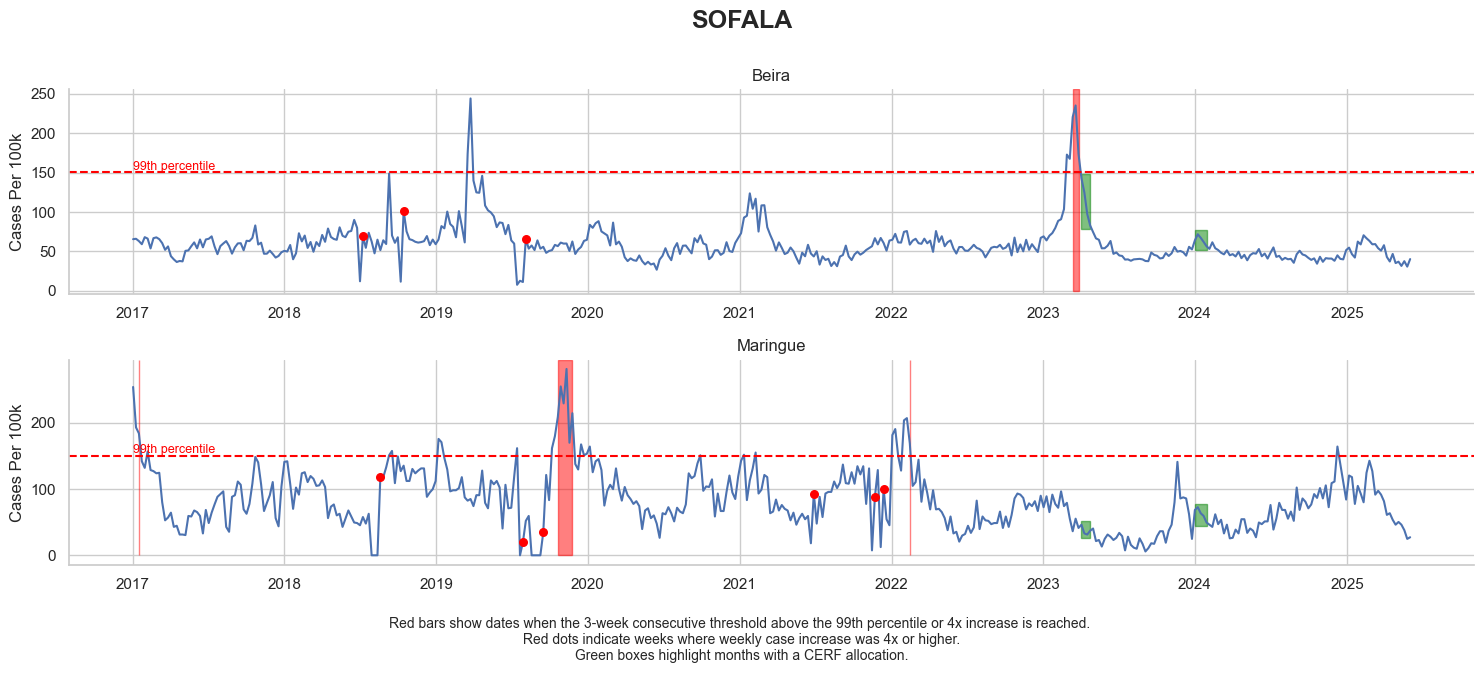

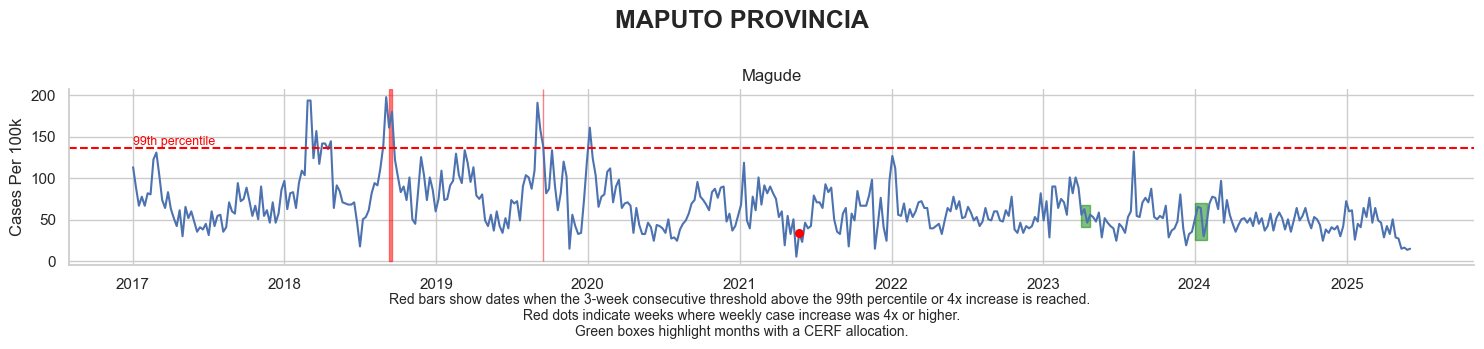

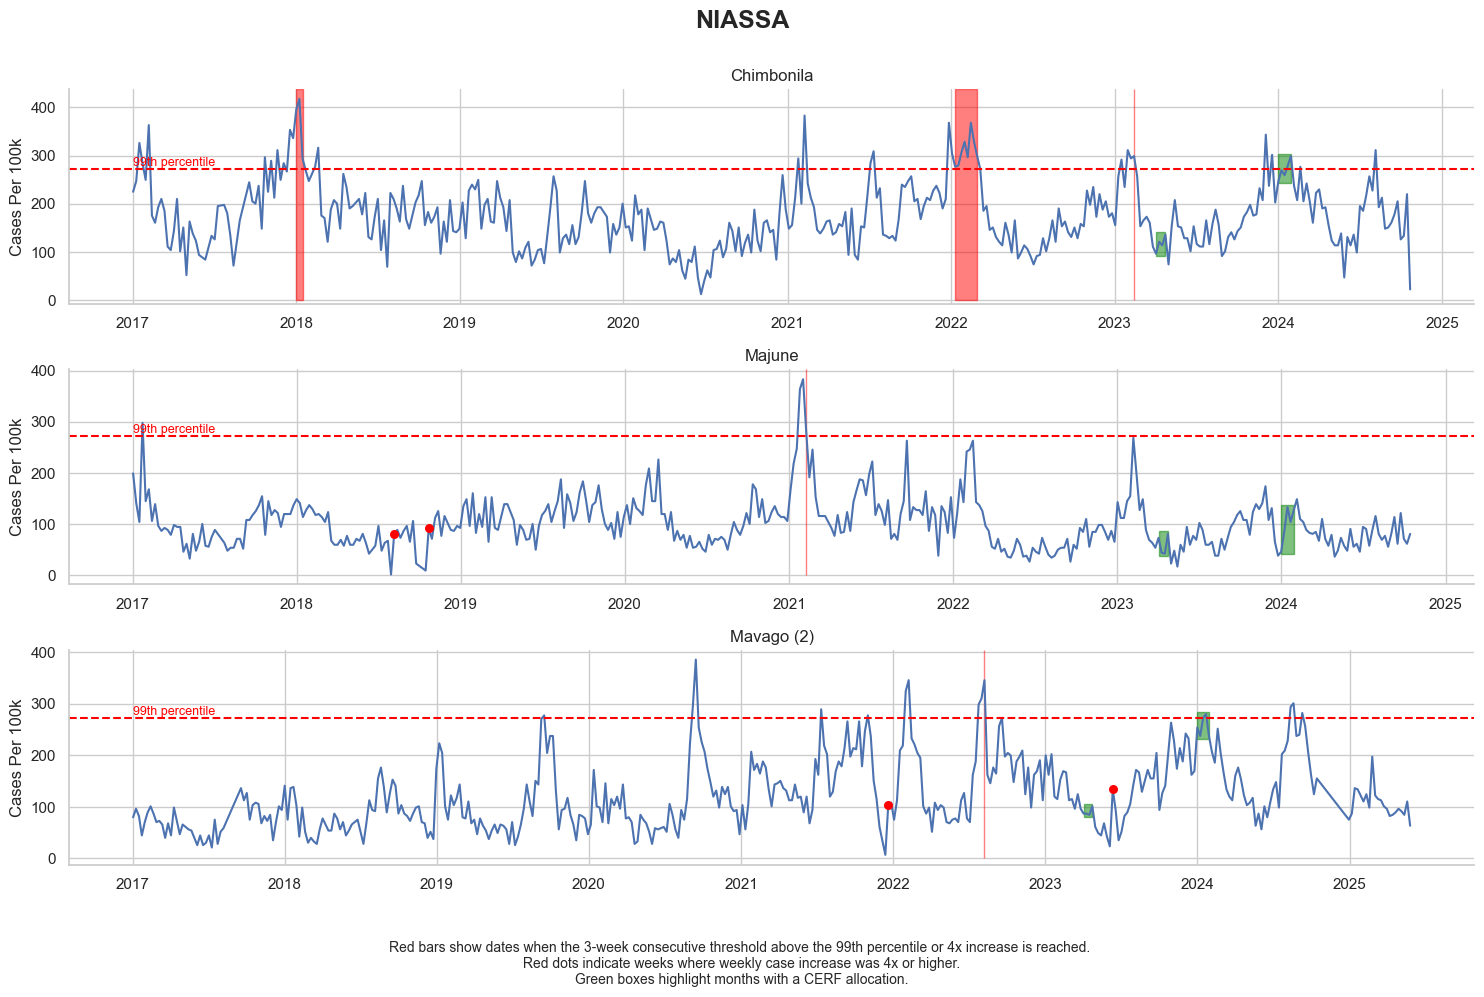

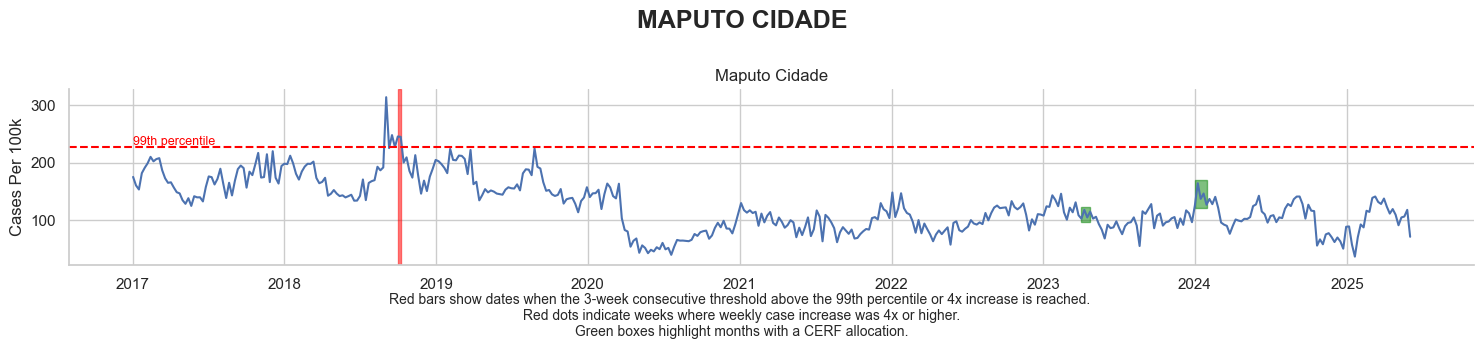

In [31]:
unique_provinces = district_df_with_percentiles["province"].unique()

for province in unique_provinces:
    subset = district_df_with_percentiles[
        (district_df_with_percentiles["province"] == province)
        & (
            district_df_with_percentiles["district"].isin(
                district_trigger_99th["district"].unique()
            )
        )
    ]

    if subset.empty:
        continue

    g = sns.FacetGrid(
        subset,
        col="district",
        col_wrap=1,
        sharex=False,
        sharey=False,
        height=3,
        aspect=5,
    )

    # Plot main line
    g.map_dataframe(sns.lineplot, x="date", y="cases_per_100k")
    # g.map_dataframe(
    #    sns.lineplot,
    #    x="date",
    #    y="cases",
    #    linestyle="--",
    #    color="orange",
    #    label="Actual Cases",
    # )

    # Add horizontal 99th percentile line
    g.map_dataframe(
        lambda data, color, **kws: (
            plt.axhline(y=data["p99"].iloc[0], color="red", linestyle="--"),
            plt.text(
                data["date"].min(),
                data["p99"].iloc[0],
                "99th percentile",
                color="red",
                fontsize=9,
                verticalalignment="bottom",
                horizontalalignment="left",
            ),
        ),
    )
    g.map_dataframe(
        lambda data, **kws: plt.scatter(
            data.loc[data["weekly_pct_increase"] >= 400, "date"],
            data.loc[data["weekly_pct_increase"] >= 400, "cases_per_100k"],
            color="red",
            s=30,
            zorder=5,
        )
    )

    # Add vertical red lines where condition is true
    def add_vertical_lines(data, **kwargs):
        for date in data.loc[data["three_consec_crossing"], "date"]:
            plt.axvline(x=date, color="red", linestyle="-", linewidth=1)

    # g.map_dataframe(add_vertical_lines)
    g.map_dataframe(highlight_month_boxes)
    g.set_titles(f"{{col_name}}")
    g.set_axis_labels("", "Cases Per 100k")

    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(0)
    plt.suptitle(f"{province.upper()}", fontsize=18, weight="bold", y=1)
    plt.tight_layout()
    plt.figtext(
        0.5,
        -0.08,
        "Red bars show dates when the 3-week consecutive threshold above the 99th percentile or 4x increase is reached. \n "
        "Red dots indicate weeks where weekly case increase was 4x or higher. \n"
        "Green boxes highlight months with a CERF allocation.",
        wrap=True,
        horizontalalignment="center",
        fontsize=10,
    )
    plt.show()

In [32]:
# showing summary by province
trigger_df = district_df_with_percentiles[
    district_df_with_percentiles["three_consec_crossing"] == True
].copy()

# Extract month and year
trigger_df["month"] = pd.to_datetime(trigger_df["date"]).dt.month_name()
trigger_df["year"] = pd.to_datetime(trigger_df["date"]).dt.year

# Group by province, year, month
summary = (
    trigger_df.groupby(["ADM1_PT", "year", "month"])
    .agg(
        num_trigger_weeks=("week", "nunique"),
        cases_per_100k=("cases_per_100k", "first"),
        districts=("district", lambda x: ", ".join(sorted(set(x)))),
    )
    .reset_index()
    .rename(columns={"ADM1_PT": "province"})
    .sort_values(["province", "year", "month"])
)
summary["district_count"] = (
    summary["districts"]
    .str.split(",")
    .apply(lambda x: len([d.strip() for d in x if d.strip()]))
)
summary = summary[summary["district_count"] >= number_of_districts]

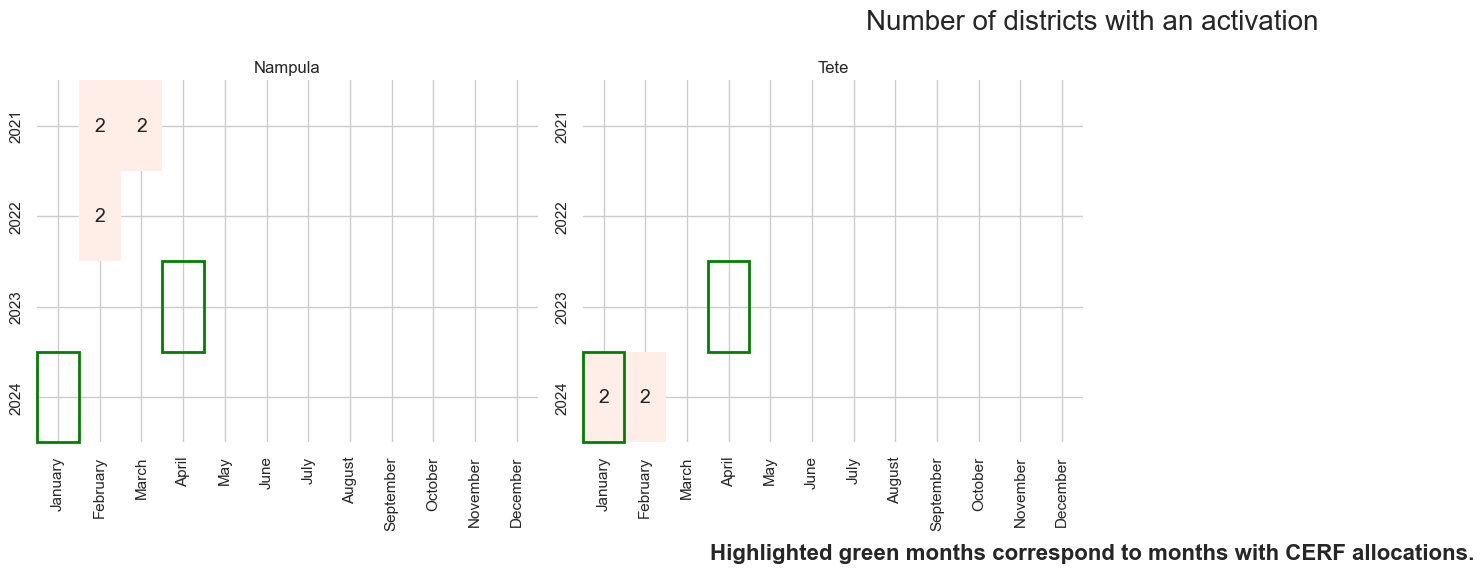

In [33]:
# Pivot the data
pivot_dist = summary.pivot_table(
    values="district_count",
    index="year",
    columns="month",
    aggfunc="mean",
    observed=False,
).sort_index()

all_years = list(range(summary["year"].min(), summary["year"].max() + 1))

# Faceted heatmap
g = sns.FacetGrid(
    summary,
    col="province",
    col_wrap=4,
    height=5.5,
    aspect=1,
    sharex=False,
    sharey=False,
)


def heatmap_with_all_years(data, **kwargs):
    table = data.pivot_table(
        index="year",
        columns="month",
        values="district_count",
        aggfunc="first",
        observed=False,
    ).reindex(index=all_years, columns=month_order)

    sns.heatmap(
        table,
        cmap="Reds",
        cbar=False,
        annot=True,
        fmt=".0f",
        linewidths=0,
        linecolor=None,
        vmin=1,
        vmax=25,
        annot_kws={"size": 14},
    )
    ax = plt.gca()

    # Loop and draw rectangles
    for year, month in highlight_cells:
        try:
            row_idx = table.index.get_loc(year)
            col_idx = table.columns.get_loc(month)
            ax.add_patch(
                plt.Rectangle(
                    (col_idx, row_idx),
                    1,
                    1,
                    fill=False,
                    edgecolor="green",
                    linewidth=2,
                    clip_on=False,
                )
            )
        except KeyError:
            continue


g.map_dataframe(heatmap_with_all_years)
g.set_titles(col_template="{col_name}", fontsize=20)
# ax.tick_params(axis="x", labelsize=18)
# ax.tick_params(axis="y", labelsize=18)
g.set_axis_labels("", "")
g.fig.suptitle(
    "Number of districts with an activation",
    fontsize=20,
)
plt.figtext(
    0.5,
    -0.02,
    "Highlighted green months correspond to months with CERF allocations.",
    ha="center",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [41]:
trigger_df[trigger_df["province"] == "Maputo Cidade"]

province       district  year  week   cases  cases_winsorized  \
31625  Maputo Cidade  Maputo Cidade  2018  40.0 2,497.0           2,497.0   
31626  Maputo Cidade  Maputo Cidade  2018  41.0 2,491.0           2,491.0   

       district_norm      matched_name       date           ADM2_PT  \
31625  maputo cidade  Cidade De Maputo 2018-10-01  Cidade De Maputo   
31626  maputo cidade  Cidade De Maputo 2018-10-08  Cidade De Maputo   

           ADM1_PT  sum_population      ADM2_PT_norm  cases_per_100k   p99  \
31625  Maputo City     1,018,559.4  cidade de maputo           245.2 226.2   
31626  Maputo City     1,018,559.4  cidade de maputo           244.6 226.2   

       weekly_pct_increase  above_99th  above_4x  threshold_crossed  \
31625                  8.0        True     False               True   
31626                 -0.2        True     False               True   

       adm1_above_limit  adm1_threshold_crossed  three_consec_crossing  \
31625             False                   False                   True   
31626             False                   False                   True   

         month  
31625  October  
31626  October

In [ ]:
activated = summary[summary["district_count"] > 0]

activated_provinces_monthly = (
    activated[["year", "month", "province"]]
    .drop_duplicates()
    .sort_values(["year", "month", "province"])
)

activated_by_year_month = (
    activated_provinces_monthly.groupby(["year", "month"], observed=False)[
        "province"
    ]
    .apply(list)
    .reset_index()
)

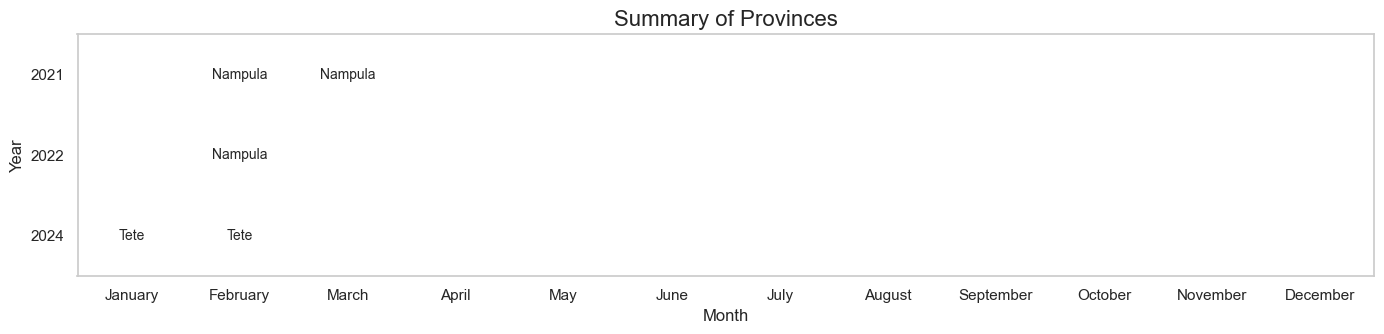

In [35]:
def parse_province_field(x):
    """Turn '[A, B]' -> ['A','B']; keep list if already list-like."""
    if isinstance(x, list):
        return x
    s = str(x).strip()
    if s.startswith("[") and s.endswith("]"):
        s = s[1:-1]
    parts = [p.strip() for p in s.split(",") if p.strip()]
    return parts


df = activated_by_year_month[
    ~activated_by_year_month["province"].isna()
].copy()
df["province_list"] = df["province"].apply(parse_province_field)
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

years = sorted(df["year"].unique())
events = df.explode("province_list").rename(
    columns={"province_list": "province_clean"}
)
events["province_clean"] = events["province_clean"].astype(str)
cell = {(y, m): [] for y in years for m in month_order}
for _, r in events.iterrows():
    cell[(r["year"], r["month"])].append(r["province_clean"])


def format_cell(provs):
    if not provs:
        return ""
    flat = []
    for p in provs:
        if isinstance(p, (list, tuple, set)):
            flat.extend(str(x).strip() for x in p if str(x).strip())
        else:
            flat.append(str(p).strip())
    uniq = sorted({x for x in flat if x})
    return "\n".join(uniq)


grid_text = [[format_cell(cell[(y, m)]) for m in month_order] for y in years]
data = np.zeros((len(years), len(month_order)))

fig, ax = plt.subplots(figsize=(14, 0.5 * len(years) + 2))
# ax.imshow(data, aspect="auto")
ax.set_facecolor("white")

for i, y in enumerate(years):
    for j, m in enumerate(month_order):
        lbl = grid_text[i][j]
        if lbl:
            ax.text(
                j,
                i,
                lbl,
                ha="center",
                va="center",
                linespacing=1.1,
                fontsize=10,
            )

ax.set_xticks(range(len(month_order)))
ax.set_xticklabels(month_order, rotation=0)
ax.set_yticks(range(len(years)))
ax.set_yticklabels(years)
ax.set_xlim(-0.5, len(month_order) - 0.5)
ax.set_ylim(len(years) - 0.5, -0.5)
ax.grid(False)
ax.set_xlabel("Month")
ax.set_ylabel("Year")
ax.set_title("Summary of Provinces", fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\pauni\AppData\Local\Temp\ipykernel_20756\3530490232.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_with_cooldown, months=2)


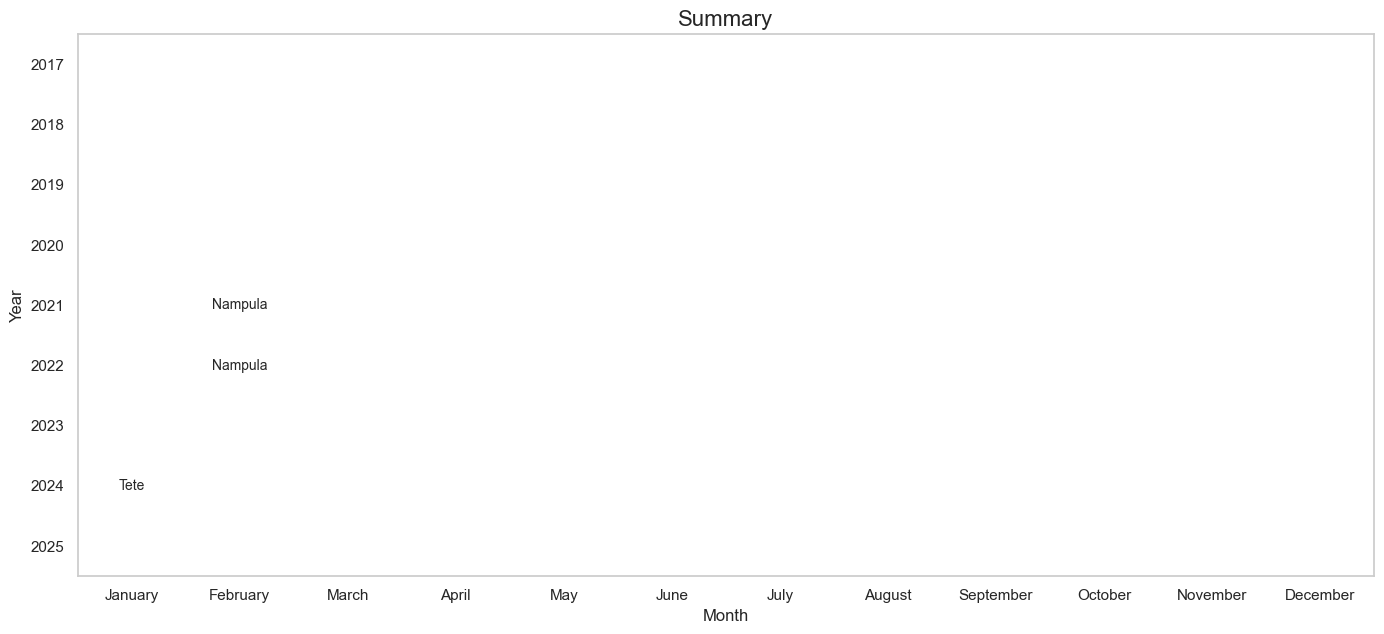

In [36]:
# build a monthly date for cooldown
m2n = {m: i + 1 for i, m in enumerate(month_order)}
events["month_num"] = events["month"].astype(str).map(m2n).astype(int)
events["date"] = pd.to_datetime(
    events["year"].astype(int).astype(str)
    + "-"
    + events["month_num"].astype(int).astype(str).str.zfill(2)
    + "-01"
)


# keep at most one activation per province every 2 months
def keep_with_cooldown(g, months=2):
    g = g.sort_values("date")
    keep = []
    next_ok = pd.Timestamp.min
    for d in g["date"]:
        if d >= next_ok:
            keep.append(True)
            next_ok = d + pd.DateOffset(months=months)
        else:
            keep.append(False)
    return g.loc[keep]


events_cd = (
    events.groupby("province_clean", group_keys=False)
    .apply(keep_with_cooldown, months=2)
    .reset_index(drop=True)
)

# --- rebuild the cell grid from filtered events ---
years = list(range(2017, 2026))  # force 2017–2025
cell = {(y, m): [] for y in years for m in month_order}
for _, r in events_cd.iterrows():
    cell[(int(r["year"]), str(r["month"]))].append(r["province_clean"])


def format_cell(provs):
    if not provs:
        return ""
    flat = []
    for p in provs:
        flat.extend(p if isinstance(p, (list, tuple, set)) else [p])
    return "\n".join(sorted({str(x).strip() for x in flat if str(x).strip()}))


grid_text = [[format_cell(cell[(y, m)]) for m in month_order] for y in years]

# --- plotting stays the same ---
fig, ax = plt.subplots(figsize=(14, 0.5 * len(years) + 2))
ax.set_facecolor("white")
for i, y in enumerate(years):
    for j, m in enumerate(month_order):
        lbl = grid_text[i][j]
        if lbl:
            ax.text(
                j,
                i,
                lbl,
                ha="center",
                va="center",
                linespacing=1.1,
                fontsize=10,
            )

ax.set_xticks(range(len(month_order)))
ax.set_xticklabels(month_order)
ax.set_yticks(range(len(years)))
ax.set_yticklabels(years)
ax.set_xlim(-0.5, len(month_order) - 0.5)
ax.set_ylim(len(years) - 0.5, -0.5)
ax.grid(False)
ax.set_xlabel("Month")
ax.set_ylabel("Year")
ax.set_title("Summary", fontsize=16)
plt.tight_layout()
plt.show()

In [37]:
# keep only provinces that have data
provinces = [
    p
    for p in district_df_with_percentiles["province"].dropna().unique()
    if not district_df_with_percentiles.loc[
        district_df_with_percentiles["province"] == p
    ].empty
]
n_prov = len(provinces)

fig, axes = plt.subplots(
    n_prov, 1, figsize=(18, 3.5 * n_prov), sharex=False, dpi=450
)
if n_prov == 1:
    axes = [axes]

for ax, province in zip(axes, provinces):
    # all districts in the province (include all, not just triggered ones)
    province_df = district_df_with_percentiles[
        district_df_with_percentiles["province"] == province
    ]

    # aggregate totals per date
    agg = (
        province_df.groupby("date", as_index=False)
        .agg({"cases": "sum", "cases_per_100k": "sum"})
        .sort_values("date")
    )

    # threshold dates from triggered districts in this province
    subset_trigger = province_df[
        province_df["district"].isin(
            district_trigger_99th["district"].unique()
        )
    ]
    # threshold months where ≥2 districts in this province are True
    subset_trigger = province_df[
        province_df["district"].isin(
            district_trigger_99th["district"].unique()
        )
    ]
    trig = subset_trigger.loc[
        subset_trigger["three_consec_crossing"], ["date", "district"]
    ].copy()
    trig["month_period"] = pd.to_datetime(trig["date"]).dt.to_period("M")

    if trig.empty:
        months_to_highlight = set()
    else:
        per_month_n = trig.groupby("month_period")["district"].nunique()
        is_maputo_cidade = str(province).strip().lower() in {
            "maputo cidade",
            "maputo city",
        }
        thresh = 1 if is_maputo_cidade else number_of_districts
        months_to_highlight = set(per_month_n.loc[per_month_n >= thresh].index)

    # mark agg by month (so highlight_month_boxes shades only these months)
    agg["month_period"] = pd.to_datetime(agg["date"]).dt.to_period("M")
    agg["three_consec_crossing"] = agg["month_period"].isin(
        months_to_highlight
    )

    # plot on this subplot
    ax.plot(agg["date"], agg["cases"], linewidth=1.5)
    plt.sca(ax)  # make sure highlight_month_boxes draws on this ax
    highlight_month_boxes(agg, cerf_y_lim="cases")

    ax.set_title(f"{province} - Total Number of Cholera Cases")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cases")
    ax.tick_params(axis="x", rotation=0)
    ax.grid(False)

plt.suptitle(
    "Provincial Cholera Cases with Activations Highlighted in Red and CERF Allocation Months in Green",
    fontsize=18,
    y=1,
)

plt.tight_layout()
plt.show()